In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# DATA

In [2]:
# Expected return
mu = np.array([0.01, -0.01, 0.03, -0.03, 0.05, -0.05])
# Covariance matrix
sigma_vals = np.array([
    0.06101, 0.02252, 0.03315, 0.03971, 0.04186, 0.04520,
    0.02252, 0.08762, 0.04137, 0.04728, 0.05241, 0.05310,
    0.03315, 0.04137, 0.10562, 0.06210, 0.06885, 0.06574,
    0.03971, 0.04728, 0.06210, 0.11357, 0.07801, 0.07790,
    0.04186, 0.05241, 0.06885, 0.07801, 0.19892, 0.09424,
    0.04520, 0.05310, 0.06574, 0.07790, 0.09424, 0.36240
])
sigma = sigma_vals.reshape((6, 6))  # 6x6 covariance matrix

# Part I : Equal risk contribution

In [43]:
# Question 1 - What is the objective function?
def obj_logw_long_only(w):
    return -np.sum(np.log(w))

In [44]:
# Question 2 - What is the associated gradient?
def grad_logw_long_only(w):
    grad = -1.0/w
    return grad

Constraint: portfolio risk (volatility) equals or is below target.
We set it as inequality: riskTarget - sqrt(w^T Σ w) >= 0.

In [45]:
def constr_volatility(w, riskTarget, covMatrix):
    # Question 3 - What is the volatility of the portfolio?
    risk = np.sqrt(np.dot(w, np.dot(covMatrix, w)))
    
    # Constraint function: riskTarget - risk must be >= 0.
    con_value = riskTarget - risk
    
    # Question 4 - What is the associated gradient?
    jac = -np.dot(covMatrix, w) / risk
    
    return con_value, jac

def constr_fun(w, riskTarget, covMatrix):
    con_val, _ = constr_volatility(w, riskTarget, covMatrix)
    return con_val

def constr_jac(w, riskTarget, covMatrix):
    jac = constr_volatility(w, riskTarget, covMatrix)
    return jac

In [46]:
# Optimisation code
numAssets = sigma.shape[1]
initial = np.ones(numAssets)
initial = initial / np.sum(initial)
riskTarget = np.sqrt(np.dot(initial, np.dot(sigma, initial)))

# Define bounds: each weight between 1e-6 and 1
bounds = [(1e-6, 1) for _ in range(numAssets)]
# Notes:
# Lower bound is used at 1e-6 and not 0 to ensure that weights remain > 0 for log function.


# Run optimization (long-only)
cons = {'type': 'ineq',
        'fun': lambda w: constr_fun(w, riskTarget, sigma),
        'jac': lambda w: np.asarray(constr_jac(w, riskTarget, sigma)[1]).ravel()}

res0 = minimize(fun = obj_logw_long_only,
                x0 = initial,
                method = 'SLSQP',
                jac = lambda w: grad_logw_long_only(w),
                bounds = bounds,
                constraints = cons,
                options = {'maxiter': 500, 'disp': False})

In [47]:
print("Part I : Equal risk contribution")
# Question 5 & 6 - What is the optimized portfolio? What are the risk contributions of the assets? Check that the risk contributions of the assets are identical

# Normalize solution to sum to one
w_sol = res0.x / np.sum(res0.x)
print("Optimal weights:", w_sol)
# Compute risk contributions of each asset:
risk_contrib = w_sol * (np.dot(sigma, w_sol) / np.sqrt(np.dot(w_sol, np.dot(sigma, w_sol))))
print("Risk contributions:", risk_contrib)
# Compute total risk of portfolio:
total_risk = np.sqrt(np.dot(w_sol, np.dot(sigma, w_sol)))
print("Portfolio risk:", total_risk)

Part I : Equal risk contribution
Optimal weights: [0.24364345 0.201993   0.1687607  0.15375335 0.12623678 0.10561272]
Risk contributions: [0.04088842 0.04088818 0.04088843 0.04088851 0.04088826 0.04088849]
Portfolio risk: 0.24533027491535558


# Part II : Long / short optimisation

In [48]:
# Objective: minimize - sum( |mu| * log(|w|) )
def obj_logw_long_short(w, mu):
    obj = -np.sum(np.abs(mu) * np.log(np.abs(w)))
    return obj

def grad_logw_long_short(w, mu):
    grad = -np.abs(mu) / w
    return grad

# Use same volatility constraint as before (using riskTarget computed from initial weights)
# Set initial weights: +1 for mu>0, -1 for mu<0, normalized by count of positives
initial_ls = np.zeros(numAssets)
initial_ls[mu > 0] = 1
initial_ls[mu < 0] = -1
count_positive = np.sum(mu > 0)
initial_ls = initial_ls / count_positive
riskTarget_ls = np.sqrt(np.dot(initial_ls, np.dot(sigma, initial_ls)))

In [49]:
#Question 7 & 8  - Determine lb and ub
# Set bounds: for assets with mu > 0: [1e-6, 1], for mu < 0: [-1, -1e-6]
bounds_ls = [(1e-6, 1) if mu[i] > 0 else (-1, -1e-6) for i in range(numAssets)]

In [50]:
# Constraint remains the same form (volatility constraint)
cons_ls = {'type': 'ineq',
           'fun': lambda w: constr_fun(w, riskTarget_ls, sigma),
           'jac': lambda w: np.asarray(constr_jac(w, riskTarget, sigma)[1]).ravel()}

res1 = minimize(fun = obj_logw_long_short,
                x0 = initial_ls,
                args = (mu),
                method = 'SLSQP',
                jac = grad_logw_long_short,
                bounds = bounds_ls,
                constraints = cons_ls,
                options = {'maxiter': 500, 'disp': False})

print("Part II : Long / short optimisation")
w_ls = res1.x
print("Optimal long/short weights:", w_ls)
print("Sum weights:", np.sum(w_ls))

# (optionnel) risque et RC pour vérifier
total_risk_ls = np.sqrt(np.dot(w_ls, np.dot(sigma, w_ls)))
print("Portfolio risk:", total_risk_ls)

Part II : Long / short optimisation
Optimal long/short weights: [ 0.30210994 -0.24790741  0.43761774 -0.51670409  0.39819985 -0.2601219 ]
Sum weights: 0.11319413537237372
Portfolio risk: 0.25184235455759524


# Part III : Long / short optimisation with market neutrality constraint

In [51]:
# Define equality constraint: sum(w) == 0
def eq_market_neutral(w):
    return np.sum(w)

def eq_market_neutral_jac(w):
    return np.ones_like(w)

In [52]:
cons_eq = [{'type': 'ineq',
            'fun': lambda w: constr_fun(w, riskTarget_ls, sigma),
            'jac': lambda w: np.asarray(constr_jac(w, riskTarget, sigma)[1]).ravel()},
           {'type': 'eq',
            'fun': lambda w: eq_market_neutral(w),
            'jac': lambda w: np.asarray(constr_jac(w, riskTarget, sigma)[1]).ravel()}]

res2 = minimize(fun = obj_logw_long_short,
                x0 = initial_ls,
                args = (mu),
                method = 'SLSQP',
                jac = grad_logw_long_short,
                bounds = bounds_ls,
                constraints = cons_eq,
                options = {'maxiter': 500, 'disp': False})

In [53]:
print("Part III : Long / short optimisation with market neutrality constraint")
w_ls = res1.x          # Part II
w_lsmn = res2.x        # Part III

print("Weights (Part II - Long/Short):", w_ls)
print("Sum weights (Part II):", np.sum(w_ls))

print("Weights (Part III - L/S Market Neutral):", w_lsmn)
print("Sum weights (Part III, should be 0):", np.sum(w_lsmn))

# Compare risks
risk_ls = np.sqrt(w_ls @ sigma @ w_ls)
risk_lsmn = np.sqrt(w_lsmn @ sigma @ w_lsmn)
print("Risk (Part II):", risk_ls)
print("Risk (Part III):", risk_lsmn)

# Optional: compare gross exposure (|w| sum)
print("Gross exposure (Part II):", np.sum(np.abs(w_ls)))
print("Gross exposure (Part III):", np.sum(np.abs(w_lsmn)))

Part III : Long / short optimisation with market neutrality constraint
Weights (Part II - Long/Short): [ 0.30210994 -0.24790741  0.43761774 -0.51670409  0.39819985 -0.2601219 ]
Sum weights (Part II): 0.11319413537237372
Weights (Part III - L/S Market Neutral): [ 0.33333333 -0.33333333  0.33333333 -0.33333333  0.33333333 -0.33333333]
Sum weights (Part III, should be 0): 1.581845765485923e-11
Risk (Part II): 0.2518423545575953
Risk (Part III): 0.2518421022078009
Gross exposure (Part II): 2.1626609225885294
Gross exposure (Part III): 2.00000000001404


# Part IV : Rolling ERC Portfolios

In [54]:
# Question 11 - Building ERC rolling portfolios

# Read CSV data (adjust the path if needed)
# The CSV is assumed to use ";" as separator, with decimal ".", and the first column as index.
stocks = pd.read_csv("Tutorial2_MVO.csv", sep = ";", decimal = ".", index_col = 0)
# Assume there is a column "Index" for dates (if not, you can use the index)
dates = stocks.index
# Select the four stock columns
values = stocks[['Walmart', 'Nike', 'CocaCola', 'Citigroup']]
print("Data shape (prices):", values.shape)

Data shape (prices): (3286, 4)


In [55]:
# Compute returns for each asset
returns = values.pct_change().dropna()

# Annualize the covariance matrix (assuming 252 trading days)
Sigma_ret = returns.cov() * 252

numAssets_mvo = Sigma_ret.shape[0]
num_obs = returns.shape[0]

index_rebal = np.arange(500, num_obs - 22 + 1, 22)

# Prepare an empty weights array (rows = observations, columns = assets)
Weights = np.full((num_obs, numAssets_mvo), np.nan)

# Use equal weights as initial guess
initial_mvo = np.ones(numAssets_mvo) / numAssets_mvo

In [56]:
# Loop over rebalancing dates; use the prior 252 observations for covariance estimation.
for Ind in index_rebal:
    start_idx = Ind - 252
    end_idx = Ind + 1  # include Ind
    if start_idx < 0:
        continue

    returns_tmp = returns.iloc[start_idx:end_idx, :]
    Sigma_tmp = returns_tmp.cov() * 252
    riskTarget_tmp = np.sqrt(np.dot(initial_mvo, np.dot(Sigma_tmp, initial_mvo)))

    # Set up optimizer for long-only ERC (using our earlier long-only objective)
    cons_tmp = {'type': 'ineq',
                'fun': lambda w: constr_fun(w, riskTarget_tmp, Sigma_tmp),
                'jac': lambda w: np.asarray(constr_jac(w, riskTarget_tmp, Sigma_tmp)[1]).ravel()}

    # Bounds strictly positive for log
    bounds = [(1e-6, 1) for _ in range(numAssets_mvo)]

    res_tmp = minimize(
        fun=obj_logw_long_only,
        x0=initial_mvo,
        method='SLSQP',
        bounds=bounds,
        constraints=[cons_tmp],
        options={'maxiter': 500, 'ftol': 1e-12, 'disp': False}
    )

    if not res_tmp.success:
        print(f"Optimization failed at Ind={Ind}: {res_tmp.message}")
        continue

    x = res_tmp.x
    s = np.sum(x)
    if s <= 1e-12:
        print(f"Sum of weights is ~0 at Ind={Ind}, skipping")
        continue

    rpWeight = x / s

    # Fill the weights for the next 22 observations (from Ind+1 to Ind+22)
    end_fill = min(Ind + 22, num_obs)
    Weights[Ind+1:end_fill, :] = np.tile(rpWeight, (end_fill - (Ind+1), 1))

Optimization failed at Ind=654: Positive directional derivative for linesearch
Optimization failed at Ind=786: Positive directional derivative for linesearch


c:\Users\Emile\anaconda3\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimization failed at Ind=1622: Positive directional derivative for linesearch


In [57]:
# Remove any rows that are all NaN (i.e. before the first rebalancing)
valid_weights = Weights[~np.isnan(Weights).all(axis=1)]
time_axis = np.arange(valid_weights.shape[0])

# Create a DataFrame for plotting
df_weights = pd.DataFrame(valid_weights, columns=['Walmart', 'Nike', 'CocaCola', 'Citigroup'])
df_weights.index = time_axis

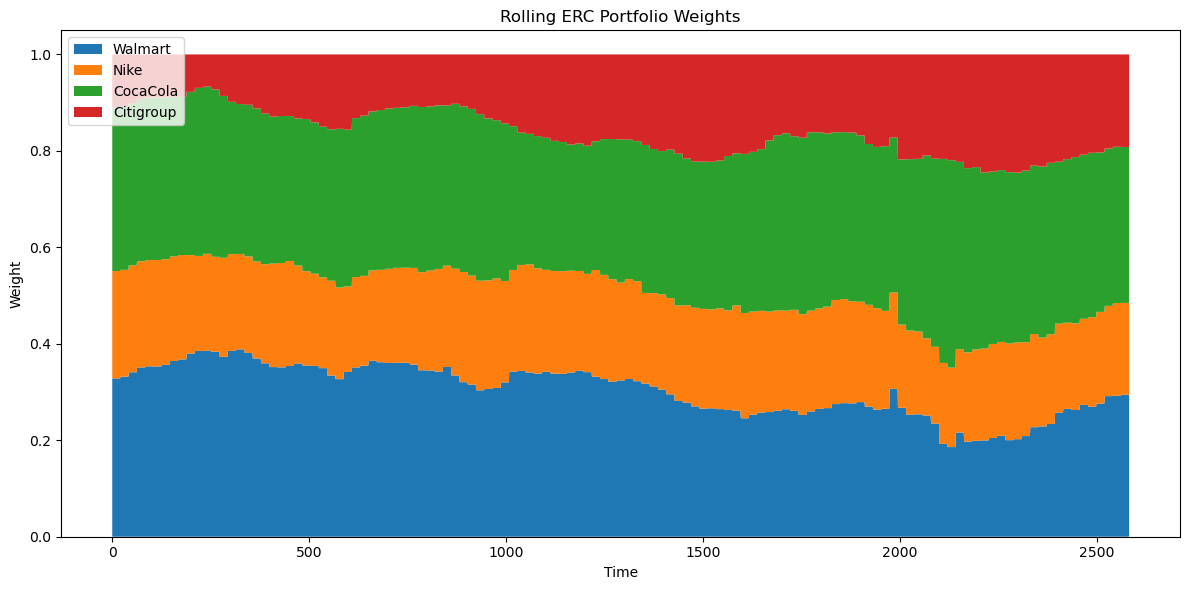

In [58]:
# Question 12 - Draw a graph of these portfolios
plt.figure(figsize=(12, 6))
plt.stackplot(df_weights.index,
              df_weights['Walmart'],
              df_weights['Nike'],
              df_weights['CocaCola'],
              df_weights['Citigroup'],
              labels=df_weights.columns)
plt.legend(loc='upper left')
plt.title('Rolling ERC Portfolio Weights')
plt.xlabel('Time')
plt.ylabel('Weight')
plt.tight_layout()
plt.show()